In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tsai.basics import *

v:\Git\Donguri\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
my_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.9.19
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.32
torch           : 2.1.2+cu118
device          : 1 gpu (['NVIDIA GeForce GTX 1080 Ti'])
cpu cores       : 4
threads per cpu : 2
RAM             : 31.94 GB
GPU memory      : [11.0] GB


In [3]:
set_seed(137, False)

In [4]:
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")  # Use GPU

Using GPU


# Global variables

In [ ]:
best_t_windows = 180
best_v_windows = 43
fcst_horizon = 5
num_y = 14

n_epochs = 40
batch_size = 16

# Define training data

In [5]:
train_df = pd.read_csv("data/for_model/train_custom_scaled.csv")
train_df

,BP_Real Upper Band,BP_Real Middle Band,BP_Real Lower Band,BP_treasuryStock,BP_inventory,BP_investments,BP_totalNonCurrentAssets,CMCSA_Real Upper Band,CMCSA_Real Middle Band,CMCSA_Real Lower Band,...,IBM_Close,INTC_Close,MAA_Close,ORCL_Close,PG_Close,QCOM_Close,STZ_Close,UL_Close,VZ_Close,XOM_Close
0,-1.234056,-1.624579,-1.908593,3.833576,-0.076837,0.0,-2.052613,-1.677935,-1.686172,-1.683624,...,-1.283062,-1.490397,-1.129250,-1.501366,-1.258842,-1.222526,-1.579980,-2.141186,-2.575620,-1.312829
1,-1.238543,-1.613131,-1.881573,3.833576,-0.076837,0.0,-2.052613,-1.678084,-1.686437,-1.684003,...,-1.176900,-1.453829,-1.079769,-1.458265,-1.254374,-1.184254,-1.576151,-2.079095,-2.474702,-1.201198
2,-1.245591,-1.600110,-1.848795,3.833576,-0.076837,0.0,-2.052613,-1.678144,-1.686598,-1.684287,...,-1.206256,-1.443051,-1.080744,-1.466051,-1.245096,-1.171792,-1.572449,-2.083377,-2.495438,-1.191895
3,-1.253398,-1.584674,-1.810574,3.833576,-0.076837,0.0,-2.052613,-1.678092,-1.686413,-1.683960,...,-1.104114,-1.431503,-1.074407,-1.441581,-1.237536,-1.161173,-1.570407,-2.078024,-2.482996,-1.175770
4,-1.276100,-1.564603,-1.747907,3.833576,-0.076837,0.0,-2.052613,-1.678159,-1.686205,-1.683418,...,-1.169662,-1.455369,-1.113406,-1.366781,-1.242691,-1.155569,-1.573598,-2.117634,-2.480232,-1.223524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255,1.919517,2.114512,2.161624,0.872219,0.156092,0.0,-1.266852,1.144488,1.065408,0.966722,...,-0.367009,-0.154322,1.043279,3.692112,2.088844,1.118303,1.666010,0.590827,-2.155357,1.702449
3256,1.941277,2.123437,2.156688,0.872219,0.156092,0.0,-1.266852,1.156470,1.075227,0.973988,...,-0.504538,-0.211291,1.047667,3.573655,2.081972,1.086152,1.660394,0.595109,-2.136003,1.815940
3257,1.966377,2.136006,2.155444,0.872219,0.156092,0.0,-1.266852,1.173400,1.086314,0.978258,...,-0.473976,-0.180497,1.008911,3.567538,2.055168,1.057835,1.635634,0.610097,-2.093147,1.850670
3258,1.969553,2.151183,2.181873,0.872219,0.156092,0.0,-1.266852,1.186054,1.097377,0.987409,...,-0.479204,-0.164330,1.010861,3.571431,2.086439,1.028339,1.623765,0.574769,-2.046144,1.956719


In [6]:
X = np.load("data/for_model/X_scaled_custom.npy")
y = np.load("data/for_model/y_scaled_custom_14.npy")

In [7]:
def generate_tv_arrays(total_length, t_windows, v_windows, pred_window):
    t = []
    v = []
    count_t = 0
    count_v = 0
    num_v_sectors = 0
    i = 0
    while i <= total_length:
        if count_t == t_windows:
            i += pred_window - 1
            while count_v <= v_windows and i <= total_length:
                v.append(i)
                i += 1
                count_v += 1
            i += pred_window - 1
            count_t = 0
            count_v = 0
            num_v_sectors += 1
        else:
            t.append(i)
            i += 1
            count_t += 1
    return np.array(t), np.array(v), num_v_sectors

In [8]:
total_length = len(X)
total = np.arange(total_length)
train_idxs, val_idxs, num_v_sectors = generate_tv_arrays(total_length, best_t_windows, best_v_windows, fcst_horizon)

In [9]:
splits = [train_idxs, val_idxs]

In [10]:
X.shape, y.shape

((3196, 112, 60), (3196, 14, 5))

In [11]:
X_train, y_train = X[splits[0]], y[splits[0]]
X_val, y_val = X[splits[1]], y[splits[1]]

# Convert lists to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders with shuffle=False
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Callbacks

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.num_bad_epochs = 0
        self.is_better = None

    def __call__(self, val_loss):
        if self.is_better is None:
            self.is_better = lambda val_loss, best_loss: val_loss < best_loss - self.min_delta
        if self.is_better(val_loss, self.best_loss):
            self.num_bad_epochs = 0
            self.best_loss = val_loss
        else:
            self.num_bad_epochs += 1
        if self.num_bad_epochs >= self.patience:
            return True
        return False


class SaveBestModel:
    def __init__(self, model, save_path):
        self.model = model
        self.best_loss = float('inf')
        self.best_epoch = -1
        self.best_state_dict = None
        self.save_path = save_path

    def __call__(self, epoch, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.best_state_dict = self.model.state_dict()

            torch.save(self.best_state_dict, self.save_path)

    def restore_best_model(self):
        if self.best_state_dict is not None:
            self.model.load_state_dict(self.best_state_dict)

class BestValLossTracker:
    def __init__(self):
        self.best_val_loss = float('inf')

    def update(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss

    def get_best_val_loss(self):
        return self.best_val_loss

# Model

In [13]:
# Define an attention block
class AttentionBlock(nn.Module):
    def __init__(self, d_model, nheads):
        super(AttentionBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nheads)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # x shape: (sequence_length, batch_size, d_model)
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.norm(x)
        return x

# Define a convolutional encoder with attention blocks
class ConvAttentionEncoder(nn.Module):
    def __init__(self, input_dim, conv_dim, output_dim, nheads, num_attention_blocks):
        super(ConvAttentionEncoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, conv_dim[0], kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm1d(conv_dim[0])
        self.conv2 = nn.Conv1d(conv_dim[0], conv_dim[1], kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm1d(conv_dim[1])
        self.conv3 = nn.Conv1d(conv_dim[1], output_dim, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm1d(output_dim)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.attention_blocks = nn.ModuleList([
            AttentionBlock(output_dim, nheads) for _ in range(num_attention_blocks)
        ])

    def forward(self, x):
        # x shape: (batch_size, input_dim, sequence_length)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.leaky_relu(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.leaky_relu(x)
        # Transpose for attention: (batch_size, output_dim, sequence_length) -> (sequence_length, batch_size, output_dim)
        x = x.transpose(1, 2).transpose(0, 1)
        for attn_block in self.attention_blocks:
            x = attn_block(x)
        # Transpose back: (sequence_length, batch_size, output_dim) -> (batch_size, output_dim, sequence_length)
        x = x.transpose(0, 1).transpose(1, 2)
        return x

class ConvAttentionTST(nn.Module):
    def __init__(self, encoder, tst):
        super(ConvAttentionTST, self).__init__()
        self.encoder = encoder
        self.patch_tst = tst

    def forward(self, x):
        # Apply the encoder to reduce feature dimensions
        x = self.encoder(x)
        # Apply the PatchTST model
        x = self.patch_tst(x)
        return x

In [14]:
best_n_layers=4
best_n_heads=6
best_d_model=24
best_d_ff=128
best_attn_dropout=0.0
best_dropout=0.4
best_stride=1
best_patch_len=15

model = TSForecaster(X, y, splits=splits,
    batch_size=batch_size,
    arch="PatchTST",
    arch_config={
        'n_layers':best_n_layers,
        'n_heads':best_n_heads,
        'd_model':best_d_model,
        'd_ff':best_d_ff,
        'attn_dropout':best_attn_dropout,
        'dropout':best_dropout,
        'stride': best_stride,
        'patch_len': best_patch_len,
        'padding_patch': True,
    },
).model
model.to(device)

PatchTST(
  (model): _PatchTST_backbone(
    (revin_layer): RevIN()
    (padding_patch_layer): ReplicationPad1d((1, 0))
    (unfold): Unfold(kernel_size=(1, 15), dilation=1, padding=0, stride=1)
    (backbone): _TSTiEncoder(
      (W_P): Linear(in_features=15, out_features=24, bias=True)
      (dropout): Dropout(p=0.4, inplace=False)
      (layers): ModuleList(
        (0-3): 4 x _TSTiEncoderLayer(
          (self_attn): _MultiheadAttention(
            (W_Q): Linear(in_features=24, out_features=24, bias=True)
            (W_K): Linear(in_features=24, out_features=24, bias=True)
            (W_V): Linear(in_features=24, out_features=24, bias=True)
            (sdp_attn): _ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=24, out_features=24, bias=True)
              (1): Dropout(p=0.4, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.4

# Optimizer

In [16]:
optimizer = torch.optim.Adam(model.parameters())

# Loss

In [17]:
mae_loss = nn.L1Loss()

# Callbacks

In [18]:
best_lr = 0.0062640676551018355

In [19]:
lr_scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(train_loader), epochs=n_epochs)
save_best_model = SaveBestModel(model, save_path="models/patchtst_custom_full_5.pth")

# Training

Epoch [1/40], Training Loss: 1.5351, Validation Loss: 1.0792
Epoch [2/40], Training Loss: 1.2712, Validation Loss: 1.0344
Epoch [3/40], Training Loss: 1.1877, Validation Loss: 1.0913
Epoch [4/40], Training Loss: 1.1736, Validation Loss: 0.9720
Epoch [5/40], Training Loss: 1.1566, Validation Loss: 1.0183
Epoch [6/40], Training Loss: 1.1274, Validation Loss: 0.9257
Epoch [7/40], Training Loss: 1.1386, Validation Loss: 0.9462
Epoch [8/40], Training Loss: 1.1828, Validation Loss: 0.9944
Epoch [9/40], Training Loss: 1.1586, Validation Loss: 0.9168
Epoch [10/40], Training Loss: 1.2496, Validation Loss: 1.1182
Epoch [11/40], Training Loss: 1.2303, Validation Loss: 1.0061
Epoch [12/40], Training Loss: 1.1718, Validation Loss: 1.0015
Epoch [13/40], Training Loss: 1.1019, Validation Loss: 0.9886
Epoch [14/40], Training Loss: 1.0926, Validation Loss: 0.9268
Epoch [15/40], Training Loss: 1.0689, Validation Loss: 0.9159
Epoch [16/40], Training Loss: 1.0680, Validation Loss: 0.9457
Epoch [17/40], Tr

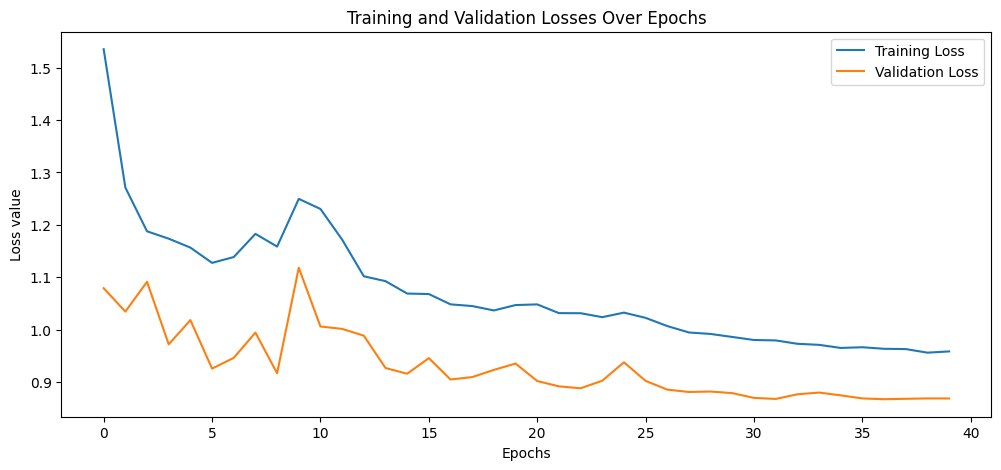

In [20]:
train_losses = [] # For plotting
val_losses = [] # For plotting
for epoch in range(n_epochs):
    # Training step
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        X_train_input, y_train_input = X_batch.to(device), y_batch.to(device)

        outputs = model(X_train_input)
        loss = 0
        for i in range(14):
            loss += mae_loss(outputs[:, -i-1, :], y_train_input[:, -i-1, :])
        running_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 1cycle
        lr_scheduler.step()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            # Validation
            X_val_input, y_val_input = X_val_batch.to(device), y_val_batch.to(device)

            val_outputs = model(X_val_input)
            val_loss = 0
            for i in range(14):
                val_loss += mae_loss(val_outputs[:, -i-1, :], y_val_input[:, -i-1, :])
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save best model (monitor val_loss)
    save_best_model(epoch, avg_val_loss)

# Plotting the losses
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()